In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
from pathlib import Path
import yaml
import torch

from matplotlib import pyplot as plt

# sys.path.append(os.path.abspath(".."))

# from rade_gs.models import RadegsModel, RadegsModelConfig
from nerfstudio.models.splatfacto import SplatfactoModel, SplatfactoModelConfig
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.data.scene_box import OrientedBox, SceneBox

from ns_extension.datamanagers.features_datamanager import FeatureSplattingDataManagerConfig, FeatureSplattingDataManager
from ns_extension.models.rade_gs_model import RadegsModelConfig, RadegsModel
from ns_extension.models.rade_features_model import RadegsFeaturesModelConfig, RadegsFeaturesModel


[Taichi] version 1.7.3, llvm 15.0.4, commit 5ec301be, linux, python 3.10.18


[I 07/10/25 19:51:03.618 67653] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


### Load configuration

In [25]:
# Find config for our current model
load_config = Path('/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/2025-07-10_183819/config.yml')

# config = yaml.load(load_config.read_text(), Loader=yaml.Loader)

### Load feature splatting pipe

In [ ]:
from nerfstudio.utils.eval_utils import eval_setup

config, pipeline, checkpoint_path, step = eval_setup(load_config)

[19:59:18] Auto image downscale factor of 2                                                 ]8;id=130812;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=833884;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

[19:59:40] use color only optimization with sigmoid activation                                         ]8;id=500568;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/models/splatfacto.py\splatfacto.py]8;;\:]8;id=5127;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/models/splatfacto.py#266\266]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/2025-07-10_183819/nerfstudio_models/step-00002
9999.ckpt

In [93]:
pipeline.model.set_text_queries(positive_queries=["fence"], negative_queries=["tree", "ground", "sky"])

/tmp/ns-extension/ns_extension/utils/camera_utils.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(get_world2view_transform(R, T, trans, scale)).transpose(0, 1).cuda()


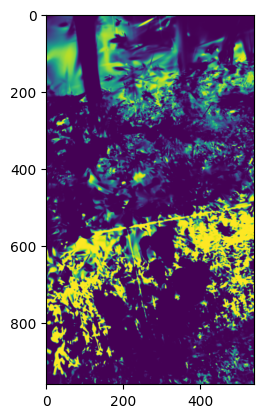

In [94]:
from matplotlib import pyplot as plt

idx = 45
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
camera = pipeline.datamanager.train_dataset.cameras[idx:idx+1].to(device)
# pipeline.datamanager

outs = pipeline.model.get_outputs_for_camera(camera)

img = outs['similarity'].detach().cpu().numpy()
plt.imshow(img)
plt.show()

/tmp/ns-extension/ns_extension/utils/camera_utils.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(get_world2view_transform(R, T, trans, scale)).transpose(0, 1).cuda()


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = config.pipeline.setup(device='cuda', test_mode='inference')

# aabb_scale = datamanager.dataparser.config.scene_scale

scene_box = SceneBox(
    aabb=torch.tensor(
        [[-aabb_scale, -aabb_scale, -aabb_scale], [aabb_scale, aabb_scale, aabb_scale]], dtype=torch.float32
    )
)

train_samples = len(datamanager.train_dataset)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Image filenames have changed, cache invalidated...

Extracting samclip features for 489 images...

Using cache found in /workspace/models/hub/facebookresearch_dinov2_main
/workspace/models/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/workspace/models/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/workspace/models/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Extracting dinov2 features:   0%|          | 0/489 [00:00<?, ?it/s]/opt/conda/envs/nerfstudio/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Extracting dinov2 features:   5%

KeyboardInterrupt: 

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = RadegsFeaturesModelConfig(output_depth_during_training=False)

config =RadegsModelConfig(output_depth_during_training=False)
config.sh_degree = 0

radegs_model = RadegsModel(config, scene_box=scene_box, num_train_data=train_samples)

# radegs_model = RadegsFeaturesModel(
#     config, 
#     scene_box=scene_box, 
#     num_train_data=train_samples,
#     metadata=datamanager.train_dataset.metadata,
# )

# radegs_model.populate_modules()
radegs_model = radegs_model.to(device)

radegs_model.eval()

# radegs_model.get_outputs(camera)

RadegsModel(
  (gauss_params): ParameterDict(
      (features_dc): Parameter containing: [torch.cuda.FloatTensor of size 50000x3 (cuda:0)]
      (features_rest): Parameter containing: [torch.cuda.FloatTensor of size 50000x0x3 (cuda:0)]
      (means): Parameter containing: [torch.cuda.FloatTensor of size 50000x3 (cuda:0)]
      (opacities): Parameter containing: [torch.cuda.FloatTensor of size 50000x1 (cuda:0)]
      (quats): Parameter containing: [torch.cuda.FloatTensor of size 50000x4 (cuda:0)]
      (scales): Parameter containing: [torch.cuda.FloatTensor of size 50000x3 (cuda:0)]
  )
  (camera_optimizer): CameraOptimizer()
  (psnr): PeakSignalNoiseRatio()
  (ssim): SSIM()
  (lpips): LearnedPerceptualImagePatchSimilarity(
    (net): _NoTrainLpips(
      (scaling_layer): ScalingLayer()
      (net): Alexnet(
        (slice1): Sequential(
          (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
          (1): ReLU(inplace=True)
        )
        (slice2): Sequent

In [20]:
features = radegs_model.distill_features
features = radegs_model.decoder.per_gaussian_forward(features)

# features.shape

In [9]:
idx = 0
camera = datamanager.train_dataset.cameras[idx:idx+1].to(device)

In [59]:
# radegs_model.set_text_queries(positive_queries=["plant"], negative_queries=["ground"])
outputs = radegs_model.get_outputs(camera)

/tmp/ns-extension/ns_extension/utils/camera_utils.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(get_world2view_transform(R, T, trans, scale)).transpose(0, 1).cuda()


### My output

In [91]:
## My rendering pipeline
from ns_extension.utils.camera_utils import depth_double_to_normal, convert_to_colmap_camera

points1, points2 = depth_double_to_normal(camera, outputs['depth'], outputs['median_depth'])

points1.shape, points2.shape

/tmp/ns-extension/ns_extension/utils/camera_utils.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(get_world2view_transform(R, T, trans, scale)).transpose(0, 1).cuda()


(torch.Size([960, 540, 3]), torch.Size([960, 540, 3]))

Original output

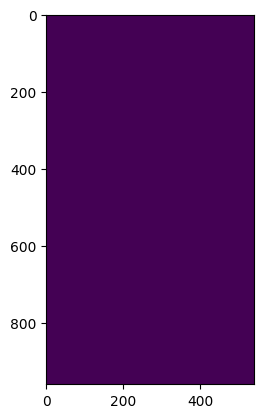

In [80]:
from matplotlib import pyplot as plt
outs = outputs['similarity'].detach().cpu().numpy()
plt.imshow(outs)
plt.show()

/tmp/ns-extension/ns_extension/utils/camera_utils.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(get_world2view_transform(R, T, trans, scale)).transpose(0, 1).cuda()


In [28]:
from nerfstudio.models.splatfacto import num_sh_bases

In [70]:
datamanager.train_dataset.metadata

{'depth_filenames': None,
 'depth_unit_scale_factor': 0.001,
 'mask_color': None,
 'points3D_xyz': tensor([[ 0.5881,  0.2354,  0.3443],
         [ 0.5153,  0.2859,  0.1964],
         [ 0.5296,  0.2778,  0.2392],
         ...,
         [ 0.4155,  0.4354,  0.4631],
         [-0.0926,  0.2761,  0.3994],
         [ 0.4062,  0.4324,  0.4728]]),
 'points3D_rgb': tensor([[174, 173, 178],
         [ 20,  10,   6],
         [104,  97,  96],
         ...,
         [ 77,  81,  59],
         [ 52,  54,  45],
         [ 41,  50,  32]], dtype=torch.uint8),
 'feature_type': 'SAMCLIP',
 'feature_dims': {'dinov2': torch.Size([384, 57, 32]),
  'samclip': torch.Size([768, 113, 64])}}

In [62]:
features_dc_crop = radegs_model.features_dc
features_rest_crop = radegs_model.features_rest

colors_crop = torch.cat((features_dc_crop[:, None, :], features_rest_crop), dim=1)

colors_crop.shape

torch.Size([50000, 16, 3])

In [15]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version PyTorch was compiled with: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

PyTorch version: 2.1.2+cu118
CUDA available: True
CUDA version PyTorch was compiled with: 11.8
Number of GPUs: 1


In [16]:
# Before calling radegs_model.get_outputs(camera)
print(f"Camera device: {camera.device if hasattr(camera, 'device') else 'No device attr'}")

# Check model parameters
for name, param in radegs_model.named_parameters():
    if param.device.type != 'cuda':
        print(f"Parameter {name} is on {param.device}")
        break

Camera device: cpu
Parameter device_indicator_param is on cpu


In [111]:
# Move the entire model to CUDA
radegs_model = radegs_model.cuda()

# Or if you want to be explicit about the device
device = torch.device('cuda:0')
radegs_model = radegs_model.to(device)

camera = camera.to('cuda:0')

In [112]:
outputs = radegs_model.get_outputs(camera)

/tmp/rade_gs/rade_gs/utils/camera_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()


In [19]:
fs_outputs = pipeline.model.get_outputs(camera)

/opt/conda/envs/nerfstudio/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


### Load Radegs pipe

In [28]:
# Find config for our current model
rade_gs_load_config = Path('/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-gs/2025-07-02_114948/config.yml')

rade_gs_config = yaml.load(rade_gs_load_config.read_text(), Loader=yaml.Loader)

# Create the environment
rade_gs_pipeline = rade_gs_config.pipeline.setup(device='cuda', test_mode='inference')

In [32]:
radegs_outs = rade_gs_pipeline.model.get_outputs(camera)

In [ ]:
pipeline.model.get_outputs()

In [38]:
camera.get_intrinsics_matrices().shape

torch.Size([1, 3, 3])

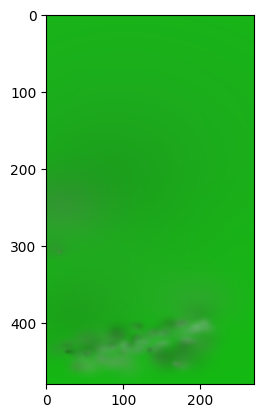

In [34]:
radegs_im = radegs_outs['rgb'].detach().cpu().numpy()
plt.imshow(radegs_im)
plt.show()